# Sector Rotation strategy with momentum
## Use Index of representative asset classes
#### Market Index ETF, sector etf, bond etf are included
#### Result is driven from 2010 to 2021 market data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from datetime import timedelta

from utils.yahoo_stock_data import yahoo_data
from utils.regular_rebalancing import momentum_rebalance_strategy

%matplotlib inline
from matplotlib import pyplot as plt

import quantstats

### Load Data of each asset classes
##### Use representative ETF to model strategy
##### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [3]:
asset_class_ticker =[
    #
    "XLB",  # The Materials Select Sector SPDR® Fund                1998-12-16
    "XLE",  # The Energy Select Sector SPDR® Fund                   1998-12-22
    "XLF",  # The Financial Select Sector SPDR® Fund                1998-12-22
    "XLI",  # The Industrial Select Sector SPDR® Fund               1998-12-22
    "XLK",  # The Technology Select Sector SPDR® Fund               1998-12-22
    "XME",  # SPDR® S&P® Metals & Mining ETF                        2006-06-23
    "XLP",  # The Consumer Staples Select Sector SPDR® Fund         1998-12-22
    "XLY",  # The Consumer Discretionary Select Sector SPDR® Fund   1998-12-22
    "XLU",  # The Utilities Select Sector SPDR® Fund                1998-12-22
    "XLV",  # The Health Care Select Sector SPDR® Fund              1998-12-22
    "XPH",  # SPDR® S&P® Pharmaceuticals ETF                        2006-06-22
    "XBI",  # SPDR® S&P® Biotech ETF                                2006-02-06
    "SHY",  # iShares 1-3 Year Treasury Bond ETF                    2002-07-22

    ]
bm_class_ticker =[
    "IVV" # iShares Core S&P 500 ETF                              2000-05-15
    ]

In [4]:
# for weekly rebalance strategy
data_setting = {
    'start' : '2007-01-01',
    'end' : '2022-03-01',
    'ticker_list': asset_class_ticker,
    'rebal_period' : '1M',
}

data = yahoo_data(**data_setting)
yield_df = data.yahoo_stock_data_loading()
yield_df

# to draw benchmark
data_setting = {
    'start' : '2007-01-01',
    'end' : '2022-03-01',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1M',
}

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()

In [5]:
def sp500_buy_hold_strategy(yld_df):
    weights = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    weights.loc[:,'IVV'] = 1.00
    return weights

#### Definining Momentum in Sector Rotation Strategy
#### Select Sector ETF if following conditions satisfied
#### 1. Choose sector which show greater 12 month return (5 sectors)
#### 2. Sector should show greater 12 month return than S&P500 index
#### Choose up to five sectors and distribute equal weight
#### If fails, replace it with safety fixed income (SHY)

In [6]:
def get_momentum(yld_df):
    """
    yiled_df : dataframe with weekly yield of asset classes
    """
    momentum = pd.DataFrame(columns = yld_df.columns, index = yld_df.index)

    for asset in  yld_df.columns:
        i = 0
        for date in yld_df.index:
            # 52 weeks per year = 12 month
            if i > 12 :
                # first 12 month data (52 data points) cannot be used since 12 month lagged returns is required
                momentum.loc[date, asset] = yld_df[asset].iloc[i] / yld_df[asset].iloc[i - 12] - 1
            else:
                momentum.loc[date, asset] = 0
            i = i + 1
    momentum = momentum.replace([np.inf], 1000)
    momentum = momentum.replace([-np.inf], -1000)
    momentum = momentum.replace([np.nan], 0)
    return momentum

def select_sector(yld_df):
    momentum_df = get_momentum(yld_df)
    selected_momentum = pd.DataFrame(
        columns=['momentum_1','momentum_2','momentum_3','momentum_4','momentum_5'],
        index=momentum_df.index
    )
    selected_ticker = pd.DataFrame(
        columns=['momentum_1','momentum_2','momentum_3','momentum_4','momentum_5'],
        index=momentum_df.index
    )

    for date in momentum_df.index:

        sorted_momentum = momentum_df.loc[date].sort_values(ascending=False)

        for i in range(len(selected_momentum.columns)):
            selected_momentum.loc[date,f'momentum_{i+1}'] = sorted_momentum[i]
            selected_ticker.loc[date,f'momentum_{i+1}'] = sorted_momentum.index[i]

    return selected_ticker


def sector_momentum(yld_df):
    mom_ticker_df = select_sector(yld_df)
    mp_table = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    for date in yld_df.index:
        selected = mom_ticker_df.loc[date].tolist()
        for sel in selected:
            mp_table.loc[date, sel] = 1/5
    mp_table = mp_table.fillna(0)

    return mp_table


In [7]:
mp_table_result = sector_momentum(yield_df)
mp_table_result

,XLB,XLE,XLF,XLI,XLK,XME,XLP,XLY,XLU,XLV,XPH,XBI,SHY
Date,,,,,,,,,,,,,
2007-02-28,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-03-31,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-04-30,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-05-31,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-06-30,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2
2021-12-31,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.2
2022-01-31,0.2,0.0,0.2,0.0,0.2,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0


In [8]:
def trim_data(yld_df, mp_table, benchmark_yield_df):

    yld_df = yld_df.iloc[12 + 1:]
    mp_table = mp_table.iloc[12 + 1:]
    benchmark_yield_df = benchmark_yield_df.iloc[12 + 1:]
    return yld_df, mp_table, benchmark_yield_df
yield_df, mp_table_result, benchmark_yield_df = trim_data(yield_df, mp_table_result, benchmark_yield_df)

In [9]:
mp_table_result

,XLB,XLE,XLF,XLI,XLK,XME,XLP,XLY,XLU,XLV,XPH,XBI,SHY
Date,,,,,,,,,,,,,
2008-03-31,0.2,0.0,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
2008-04-30,0.0,0.0,0.0,0.2,0.2,0.0,0.2,0.2,0.0,0.0,0.0,0.2,0.0
2008-05-31,0.2,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0
2008-06-30,0.2,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0
2008-07-31,0.2,0.2,0.2,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2
2021-12-31,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.2
2022-01-31,0.2,0.0,0.2,0.0,0.2,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0


In [10]:
rebal_strategy = momentum_rebalance_strategy(
    strategy=sector_momentum, yld_df=yield_df,
    bm_strategy=sp500_buy_hold_strategy, bm_yld_df=benchmark_yield_df,
    lookback_period=0
)

In [11]:
rebal_strategy

,strategy_return,benchmark_return,XLB,XLE,XLF,XLI,XLK,XME,XLP,XLY,XLU,XLV,XPH,XBI,SHY,SUM
Date,,,,,,,,,,,,,,,,
2008-03-31,0,0,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2008-04-30,0.024507,0.030667,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2008-05-31,0.039217,0.02954,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2008-06-30,0.004213,-0.01509,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2008-07-31,-0.079686,-0.070736,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,0.066927,0.059617,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,1.0
2021-12-31,-0.042742,-0.02089,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.2,1.0
2022-01-31,0.051856,0.064285,0.2,0.0,0.2,0.0,0.2,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,1.0


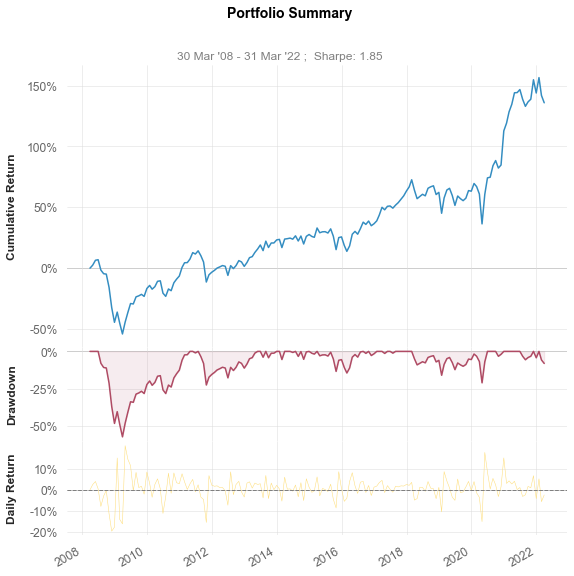

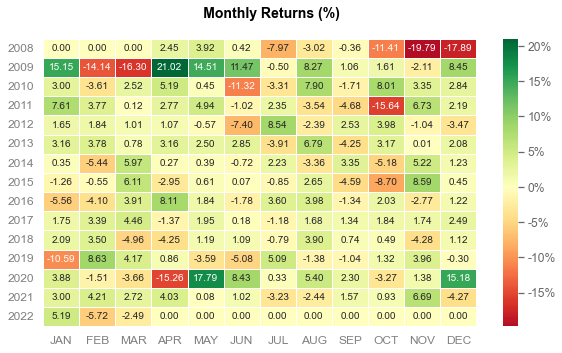

In [12]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

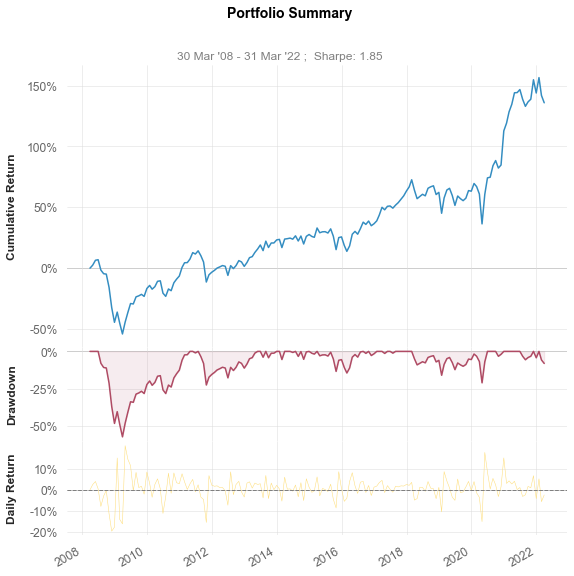

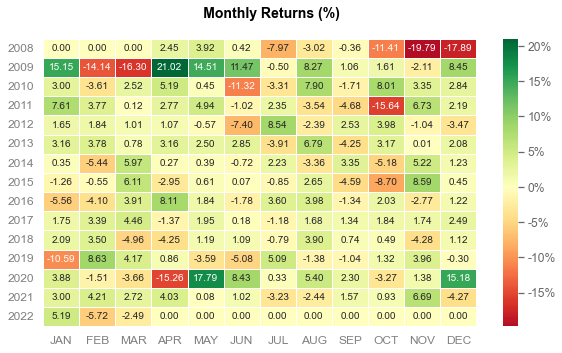

In [13]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2008-03-31  2008-03-31
End Period                 2022-03-31  2022-03-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          135.83%     326.02%
CAGR﹪                     6.32%       10.9%

Sharpe                     1.85        3.01
Smart Sharpe               1.8         2.93
Sortino                    2.7         4.37
Smart Sortino              2.62        4.25
Sortino/√2                 1.91        3.09
Smart Sortino/√2           1.85        3.0
Omega                      1.4         1.4

Max Drawdown               -57.06%     -48.93%
Longest DD Days            1003        1034
Volatility (ann.)          92.63%      83.87%
R^2                        0.86        0.86
Calmar                     0.11        0.22
Skew                       -0.35       -0.78
Kurtosis                   2.76        2

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-07-31,2009-03-31,2011-04-30,1003,-57.058620,-48.693262
2,2011-08-31,2011-10-31,2013-05-31,639,-22.436964,-17.683011
3,2018-03-31,2020-04-30,2020-06-30,822,-21.006140,-15.945203
4,2015-04-30,2016-02-29,2016-08-31,489,-14.427420,-13.370588
5,2022-02-28,2022-03-31,2022-03-31,31,-8.062367,-5.716235


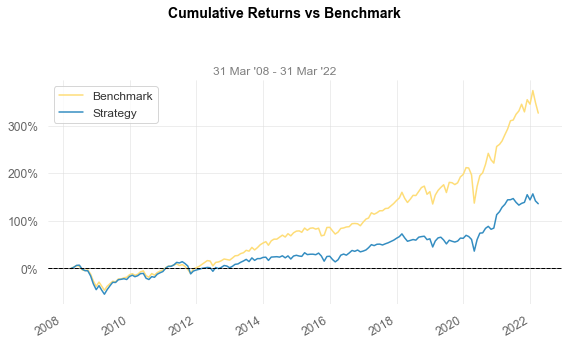

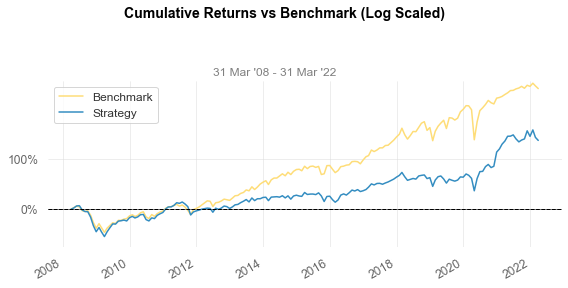

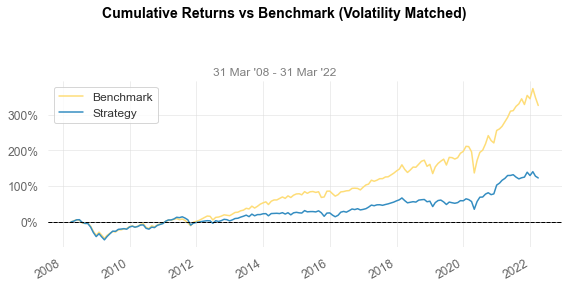

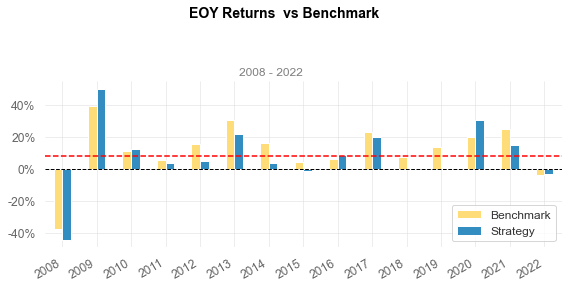

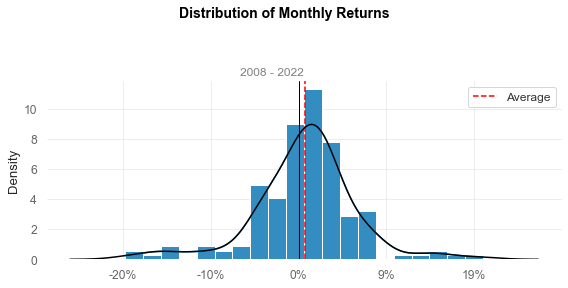

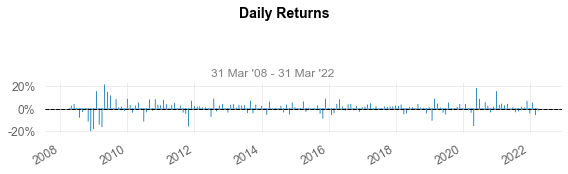

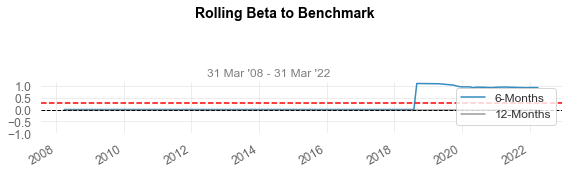

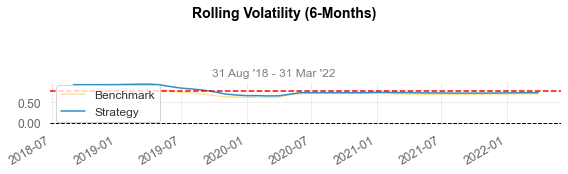

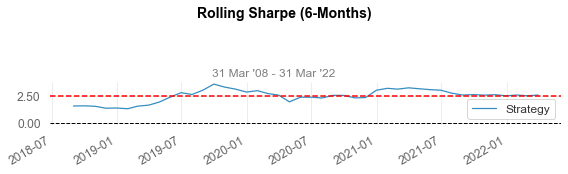

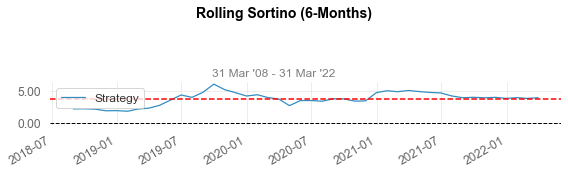

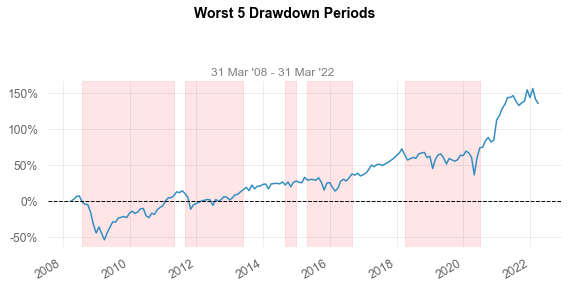

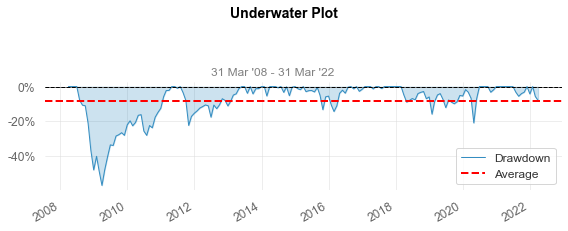

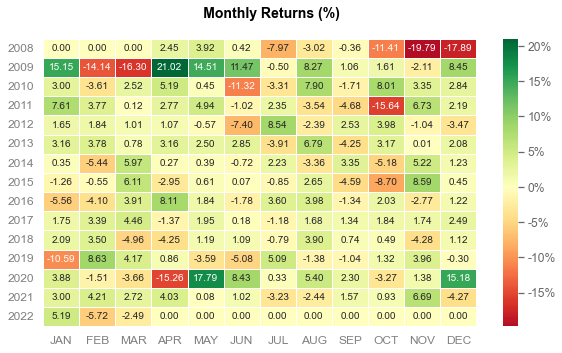

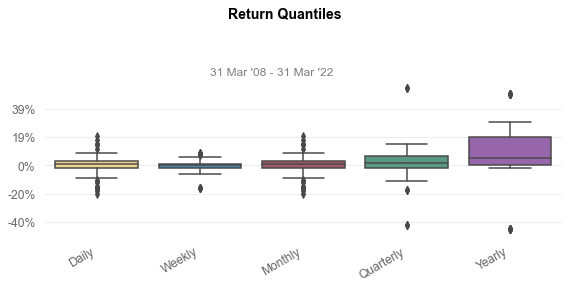

In [14]:
quantstats.reports.full(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'],)